# Centrality Measures

In [301]:
import pathlib

import jupedsim as jps
import matplotlib.pyplot as plt
import pedpy
import shapely
import sqlite3
from matplotlib.patches import Circle
from shapely import Polygon
import networkx as nx
from jupedsim.internal.notebook_utils import animate, read_sqlite_file
%matplotlib inline
import plotly.graph_objects as go

# from Py.centralityMeasures import centralityMeasuresAlgorithm
from Py.RiskSimulationValues import RiskSimulationValues
from Py.DangerSimulation import *
from Py.animation import animate
from Py.pathAlgorithms import get_sortest_path, centralityMeasuresAlgorithm, compute_efficient_paths
from Py.simulation_config import SimulationConfig
from Py.agentGroup import AgentGroup

try:
    %reload_ext autoreload
except:
    %load_ext autoreload
%autoreload 2

In [302]:
complete_area = Polygon(
    [
        (0, 0),
        (0, 15),
        (15, 15),
        (15, 0),
    ]
)
obstacles = [
    #bottom
    Polygon([(4.9, 0.0), (4.9, 1.5), (5.1, 1.5),(5.1, 0.0)]),
    Polygon([(9.9, 0.0), (9.9, 1.5), (10.1, 1.5),(10.1, 0.0)]),
    #right
    Polygon([(13.6, 4.9), (15, 4.9), (15, 5.1),(13.6, 5.1)]),
    Polygon([(13.6, 9.9), (15, 9.9), (15, 10.1),(13.6, 10.1)]),
    #top
    Polygon([(4.9, 15), (4.9, 13.6), (5.1, 13.6),(5.1, 15)]),
    Polygon([(9.9, 15), (9.9, 13.6), (10.1, 13.6),(10.1, 15)]),
    #left
    Polygon([(1.5, 4.9), (0, 4.9), (0, 5.1),(1.5, 5.1)]),
    Polygon([(1.5, 9.9), (0, 9.9), (0, 10.1),(1.5, 10.1)]),
    #center
    ## bottom left
    Polygon([(3.6, 4.9), (4.9, 4.9), (4.9, 3.6), (5.1, 3.6), (5.1, 4.9), (6.4, 4.9), (6.4, 5.1), (5.1, 5.1), (5.1, 6.5), (4.9, 6.5), (4.9, 5.1), (3.6, 5.1)  ]),
    ## bottom right
    Polygon([(8.6, 4.9), (9.9, 4.9), (9.9, 3.6), (10.1, 3.6), (10.1, 4.9), (11.5, 4.9), (11.5, 5.1), (10.1, 5.1), (10.1, 6.5), (9.9, 6.5), (9.9, 5.1), (8.6, 5.1)  ]),
    ## top left
    Polygon([(3.6, 9.9), (4.9, 9.9), (4.9, 8.6), (5.1, 8.6), (5.1, 9.9), (6.4, 9.9), (6.4, 10.1), (5.1, 10.1), (5.1, 11.5), (4.9, 11.5), (4.9, 10.1), (3.6, 10.1)  ]),
    ## top right
    Polygon([(8.6, 9.9), (9.9, 9.9), (9.9, 8.6), (10.1, 8.6), (10.1, 9.9), (11.5, 9.9), (11.5, 10.1), (10.1, 10.1), (10.1, 11.5), (9.9, 11.5), (9.9, 10.1), (8.6, 10.1)  ]),

]
exit_polygons = {'I': [(12.5, 12.5), (15, 12.5), (15, 15), (12.5, 15)]}
waypoints = {'B':([7.5, 2.5], 1.5), 'C':([12.5, 2.5], 1.5), 'D':([12.5, 7.5], 1.5), 'E':([7.5, 7.5], 1.5), 'F':([2.5, 7.5], 1.5), 'G':([2.5, 12.5], 1.5), 'H':([7.5, 12.5], 1.5)}
distribution_polygon = {'A': Polygon([[0, 0], [5, 0], [5, 5], [0, 5]])}
obstacle = shapely.union_all(obstacles)  # combines obstacle polygons into only one polygon
walkable_area = pedpy.WalkableArea(
    shapely.difference(complete_area, obstacle))  # difference subtracts obstacle form complete_area

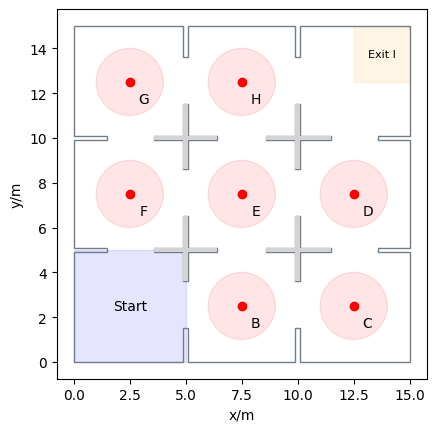

In [303]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_aspect("equal")
pedpy.plot_walkable_area(walkable_area=walkable_area, axes=ax)

for idx, (waypoint, distance) in waypoints.items():
    ax.plot(waypoint[0], waypoint[1], "ro")
    ax.annotate(
        f"{idx}",
        (waypoint[0], waypoint[1]),
        textcoords="offset points",
        xytext=(10, -15),
        ha="center",
    )
    circle = Circle(
        (waypoint[0], waypoint[1]), distance, fc="red", ec="red", alpha=0.1
    )
    ax.add_patch(circle)
for name, exit_polygon in exit_polygons.items():
    x, y = Polygon(exit_polygon).exterior.xy
    plt.fill(x, y, alpha=0.1, color="orange")
    centroid = Polygon(exit_polygon).centroid
    plt.text(centroid.x, centroid.y, f"Exit {name}", ha="center", va="center", fontsize=8)

for _, pol in distribution_polygon.items():
    x, y = pol.exterior.xy
    plt.fill(x, y, alpha=0.1, color="blue")
    centroid = pol.centroid
    plt.text(centroid.x, centroid.y, "Start", ha="center", va="center", fontsize=10)

In [304]:
def remove_obstacles_from_areas(specific_areas, obstacles):
    """
    Removes obstacles from specific areas by subtracting overlapping polygons.

    Args:
        specific_areas (dict): Dictionary of named areas {name: Polygon}.
        obstacles (list): List of Polygon objects representing obstacles.

    Returns:
        dict: Dictionary of cleaned areas {name: Polygon without obstacles}.
    """
    cleaned_areas = {}

    for name, area in specific_areas.items():
        # Subtract all obstacles from the current area
        cleaned_area = area
        for obstacle in obstacles:
            if cleaned_area.intersects(obstacle):  # Only process if they overlap
                cleaned_area = cleaned_area.difference(obstacle)

        # Store the cleaned area in the dictionary
        cleaned_areas[name] = cleaned_area

    return cleaned_areas

In [305]:
specific_areas = dict()
specific_areas['A'] = Polygon([(0,0), (5,0), (5,5), (0,5)])
specific_areas['B'] = Polygon([(5,0), (10,0), (10,5), (5,5)])
specific_areas['C'] = Polygon([(10,0), (15,0), (15,5), (10,5)])
specific_areas['D'] = Polygon([(10,5), (15,5), (15,10), (10,10)])
specific_areas['E'] = Polygon([(5,5), (10,5), (10,10), (5,10)])
specific_areas['F'] = Polygon([(0,5), (5,5), (5,10), (0,10)])
specific_areas['G'] = Polygon([(0,10), (5,10), (5,15), (0,15)])
specific_areas['H'] = Polygon([(5,10), (10,10), (10,15), (5,15)])
specific_areas['I'] = Polygon([(10,10), (15,10), (15,15), (10,15)])

In [306]:
specific_areas = remove_obstacles_from_areas(specific_areas, obstacles)

## Configuration of Simulation Scenarios

In [307]:
# Dictionary to store simulations for different percentages of agents
simulations = {}

# List of percentages of agents that will be used in the simulation
percentages = [0]

# Total number of agents in the simulation (not currently used in this snippet)
total_agents = 10

# Loop over each percentage value to create a corresponding simulation
for percentage in percentages:
    # Define the output file path for storing the simulation trajectories
    trajectory_file = f"../../sqlite_data/centrality_measures_percentage_{percentage}.sqlite"

    # Create a new simulation instance using JPS (JuPedSim)
    simulation = jps.Simulation(
        model=jps.CollisionFreeSpeedModel(  # Define the agent movement model
            strength_neighbor_repulsion=2.6,  # Strength of repulsion between neighboring agents
            range_neighbor_repulsion=0.1,  # Distance at which agents start repelling each other
            range_geometry_repulsion=0.05,  # Distance at which agents start avoiding obstacles
        ),
        geometry=walkable_area.polygon,  # Define the walkable area for the simulation
        trajectory_writer=jps.SqliteTrajectoryWriter(  # Specify where to store simulation results
            output_file=pathlib.Path(trajectory_file),  # Save output to the specified SQLite file
        ),
    )

    # Store the simulation object in the dictionary using the percentage as a key
    simulations[percentage] = simulation

## Choosing the path


In [308]:
# Create the graph
G = nx.DiGraph()

# Nodos y sus niveles iniciales de riesgo (0 a 1)
nodes = {
    "A": 0.0, "B": 0.6, "C": 0.0,
    "D": 0.6, "E": 0.6, "F": 0.1,
    "G": 0.0, "H": 0.0, "I": 0.0,
}

# Agregar nodos al grafo
for node, risk in nodes.items():
    G.add_node(node, risk=risk)

# Definir las conexiones entre nodos
edges = [
    ("A", "B"), ("A", "F"), ("B", "A"), ("B", "E"), ("B", "C"),
    ("C", "B"), ("C", "D"), ("D", "I"), ("D", "E"), ("D", "C"),
    ("E", "D"), ("E", "F"), ("E", "B"), ("E", "H"), ("F", "A"),
    ("F", "E"), ("F", "G"), ("G", "F"), ("G", "H"), ("H", "E"),
    ("H", "G"), ("H", "I"),
]

# Agregar las aristas con un costo fijo (se puede ajustar)
G.add_edges_from([(u, v, {"cost": 3}) for u, v in edges])

# Parameters for calculation
source = "A"  # Source nodes
targets = ["I"]  # Target nodes

# Calculate all efficient paths between source-target pairs
gamma = 0.2  # Time tolerance factor

_, _, best_paths = centralityMeasuresAlgorithm(G, source, targets, gamma)

## Outlining Agent Journeys

In [309]:
def create_journeys_for_simulation(start, paths, waypoint_ids, exit_ids):
    """
    Generates journey descriptions for simulation agents using the best paths obtained previously.

    Args:
        start (str): The starting node in the graph.
        paths (list): A list of paths (each path is a list of nodes).
        waypoint_ids (dict): A dictionary mapping graph node IDs to simulation waypoint IDs.
        exit_ids (dict): A dictionary mapping exit nodes to simulation exit IDs.

    Returns:
        list: A list of tuples, where each tuple contains:
              - A jps.JourneyDescription object describing the agent's journey.
              - The original path (a list of nodes) used to generate the journey.
    """
    if not paths:
        raise ValueError(f"No valid paths found from {start}.")

    journeys = []
    # Iterate over each path from the best_paths list.
    for path in paths:
        # Skip paths that do not have at least two nodes (start and end are required).
        if len(path) < 2:
            continue

        # Map the intermediate graph nodes to simulation waypoint IDs,
        # excluding the start and end nodes.
        needed_waypoints = [waypoint_ids[node] for node in path[1:-1]]
        if not needed_waypoints:
            continue

        # Ensure that the exit node (last node in the path) exists in the exit_ids dictionary.
        if path[-1] not in exit_ids:
            continue

        # Create a JourneyDescription using the intermediate waypoints and append the exit stage.
        journey = jps.JourneyDescription([*needed_waypoints, exit_ids[path[-1]]])

        # Configure transitions between waypoints.
        for idx, waypoint in enumerate(needed_waypoints):
            # If it's the last waypoint, the next stage is the exit (mapped from exit_ids);
            # otherwise, the next stage is the following waypoint.
            next_waypoint = exit_ids[path[-1]] if idx == len(needed_waypoints) - 1 else needed_waypoints[idx + 1]
            journey.set_transition_for_stage(
                waypoint, jps.Transition.create_fixed_transition(next_waypoint)
            )

        # Append the journey description along with its corresponding path.
        journeys.append((journey, path))

    return journeys

In [310]:
def set_journeys(simulation, start, paths, waypoint_ids, exit_ids):
    """
    Configures agent journeys in the simulation by setting up waypoints, exit stages,
    and journey paths between a start and end point.

    Args:
        simulation (jps.Simulation): The simulation instance where journeys are added.
        start (str): The starting node in the graph.
        end (str): The destination node in the graph.
        paths (dict): A list of paths (each path is a list of nodes)
        waypoint_ids (dict): A dictionary mapping nodes to waypoint IDs in the simulation.
        exit_ids (dict): A dictionary mapping exit nodes to simulation exit IDs.

    Returns:
        tuple:
            - journeys_id (dict): A dictionary mapping the starting node to a list of tuples (journey ID, path) for each journey.
    """

    # Generate different journey paths using the provided graph information
    journeys = create_journeys_for_simulation(start, paths, waypoint_ids, exit_ids)

    # Initialize a dictionary to store journey IDs and their associated paths
    journeys_id = {}

    # Iterate over the generated journeys and their respective paths
    for journey, path in journeys:
        # Add the journey to the simulation and retrieve its unique ID
        journey_id = simulation.add_journey(journey)

        # Ensure the starting node is initialized in the dictionary
        if start not in journeys_id:
            journeys_id[start] = []

        # Store the journey ID and its corresponding path in the dictionary
        journeys_id[start].append((journey_id, path))

    # Return the journey mapping IDs
    return journeys_id

## Allocate Agents

In [311]:
positions = jps.distribute_by_number(
    polygon=distribution_polygon[source],
    number_of_agents=total_agents,
    distance_to_agents=0.4,
    distance_to_polygon=0.7,
    seed=45131502,
)

## Launching the Simulation

In [312]:
def update_graph_risks(G, risk_per_node):
    """
    Updates the risk values for each node in the graph based on the provided risk mapping.

    Args:
        G (networkx.Graph): The graph whose nodes will have their risk attributes updated.
        risk_per_node (dict): A dictionary mapping node identifiers to their corresponding risk values.
    """
    # Iterate over each node and its associated risk value in the risk_per_node dictionary.
    for node, risk in risk_per_node.items():
        # Check if the node exists in the graph to avoid updating non-existent nodes.
        if G.has_node(node):
            # Update the 'risk' attribute of the node in the graph.
            G.nodes[node]['risk'] = risk

In [313]:
def compute_low_Knowledge_alternative_path(simulation_config, risk_per_node, next_node, current_node, agent_group, G, risk_threshold):
    """
    Computes an alternative path based on node risk values and the selected algorithm.
    If the risk of the next node is below the threshold, no update is needed and None is returned.

    Args:
        simulation_config (SimulationConfig): The simulation configuration instance.
        risk_per_node (dict): Mapping of each node to its risk value.
        next_node: The node following the current node in the current path.
        current_node: The current node in the path.
        agent_group (AgentGroup): An AgentGroup instance containing:
            - agents (list): List of agent IDs.
            - path (list): List representing the group's current path.
            - algorithm (int): Identifier for the algorithm used.
            - knowledge_level (int): The knowledge level of the agents.
        G: The graph representing the environment.
        risk_threshold (float): Threshold above which a node is considered unsafe.
    Returns:
        list or None: The best alternative path if one is found, or None if no update is needed or found.
    """

    algo = agent_group.algorithm
    current_path = agent_group.path

    # If the risk of the next node is below the threshold, no update is needed.
    if risk_per_node[next_node] < risk_threshold:
        return None

    # Update the graph with the risk values for each node.
    update_graph_risks(G, risk_per_node)

    # Sort the neighbors of the current_node by their risk (lowest risk first).
    neighbors_sorted = sorted(
        G.neighbors(current_node),
        key=lambda neighbor: G.nodes[neighbor].get('risk', float('inf'))
    )

    # Remove the starting node of the current path from the neighbors if applicable.
    if current_node != current_path[0] and current_path[0] in neighbors_sorted:
        neighbors_sorted.remove(current_path[0])

    best_path = None

    if algo == 1:
        gamma = 0.2
        # Get alternative paths using the centralityMeasuresAlgorithm.
        _, _, alternative_paths = centralityMeasuresAlgorithm(
            G, current_node, simulation_config.get_exit_ids_keys(), gamma
        )
        if alternative_paths:
            # Iterate through the sorted neighbors to find the first alternative path
            # where the second node matches one of the sorted neighbors.
            for neighbor in neighbors_sorted:
                for path in alternative_paths:
                    if len(path) > 1 and path[1] == neighbor:
                        best_path = path
                        break  # Break inner loop if a valid path is found.
                if best_path:
                    break  # Break outer loop once a valid path is found.
    elif algo == 0:
        # Use the shortest path algorithm for each neighbor.
        for neighbour in neighbors_sorted:
            best_path = get_sortest_path(G, neighbour, simulation_config.get_exit_ids_keys())
            if best_path is not None:
                best_path.insert(0, current_node)
                break

    return best_path

In [314]:
def compute_high_Knowledge_alternative_path(simulation_config, risk_per_node, current_node, agent_group, G, risk_threshold):
    """
    Computes an alternative path for a high-knowledge agent group when the current path contains nodes
    with risk values at or above a given threshold. It evaluates the risk of the current path and, if necessary,
    computes alternative paths using either centrality measures or efficient paths, selecting the path with
    the lowest total risk (excluding the first and last nodes).

    Args:
        simulation_config (SimulationConfig): Simulation configuration instance containing necessary parameters.
        risk_per_node (dict): Mapping of nodes to their risk values.
        current_node: The node from which alternative paths are evaluated.
        agent_group (AgentGroup): An AgentGroup instance containing:
            - algorithm (int): Identifier for the algorithm (e.g., 0 for efficient paths, 1 for centrality measures).
            - path (list): The current path (list of nodes) followed by the agent group.
        G (networkx.Graph): The graph representing the simulation environment.
        risk_threshold (float): The risk threshold above which a node is considered dangerous.

    Returns:
        list or None: The best alternative path (as a list of nodes) with lower total risk, or None if
                      no dangerous nodes are found in the current path.
    """
    # Retrieve the algorithm identifier and current path from the agent group.
    algo = agent_group.algorithm
    current_path = agent_group.path
    dangerous_path = False  # Flag to indicate if any node in the current path is dangerous.

    # Iterate over the nodes in the current path.
    for i, node in enumerate(current_path):
        # Check if the node's risk meets or exceeds the threshold.
        if risk_per_node.get(node, 0) >= risk_threshold:
            # If the node is the first node, skip it as there's no previous node to update from.
            if i == 0:
                continue
            dangerous_path = True

    # If a dangerous node is found in the current path, attempt to compute an alternative path.
    if dangerous_path:
        # Update the graph with the current risk values for each node.
        update_graph_risks(G, risk_per_node)

        gamma = 0.2  # Tolerance factor for path cost or risk.

        # Depending on the algorithm specified in the agent group, compute alternative paths.
        if algo == 1:
            # Use centralityMeasuresAlgorithm to compute alternative paths based on node centrality.
            _, _, alternative_paths = centralityMeasuresAlgorithm(
                G, current_node, simulation_config.get_exit_ids_keys(), gamma
            )
        elif algo == 0:
            # Use compute_efficient_paths to compute alternative efficient paths.
            alternative_paths = compute_efficient_paths(
                G, current_node, simulation_config.get_exit_ids_keys(), gamma
            )

        best_risk = float('inf')  # Initialize the best (lowest) risk value.

        # Iterate over the computed alternative paths to find the one with the lowest total risk.
        for path in alternative_paths:
            # Calculate the total risk for intermediate nodes (exclude first and last nodes).
            path_risk = sum(G.nodes[node]["risk"] for node in path[1:-1])
            # If this path has a lower risk than the current best, update best_risk and best_path.
            if path_risk < best_risk:
                best_risk = path_risk
                best_path = path
    else:
        # If no dangerous node is found in the current path, no alternative path is needed.
        return None

    # Return the alternative path with the lowest computed risk.
    return best_path

In [315]:
def is_sublist(sub, main):
    """
    Checks if 'sub' is a contiguous sublist of 'main'.

    Args:
        sub (list): The potential sublist.
        main (list): The list in which to check for the sublist.

    Returns:
        bool: True if 'sub' is a contiguous sublist of 'main', False otherwise.
    """
    n = len(sub)
    for i in range(len(main) - n + 1):
        if main[i:i+n] == sub:
            return True
    return False

In [316]:
def update_group_paths(simulation_config, risk_per_node, agent_group, G, risk_threshold=0.5):
    """
    Updates the path of a group of agents based on the current node of the first agent in the group.
    If the path is considered unsafe, the path for all agents in the group is updated.

    Args:
        simulation_config (SimulationConfig): Instance containing:
            - simulation: Object managing the simulation (agents and environment).
            - every_nth_frame (int): Interval at which agent paths are updated.
            - waypoints_ids (dict): Mapping from graph nodes to simulation waypoint IDs.
            - journeys_ids (dict): Mapping of journey identifiers to tuples (journey_id, path).
        risk_per_node (dict): Mapping of each node to its risk value.
        agent_group (AgentGroup): An AgentGroup instance containing:
            - agents (list): List of agent IDs.
            - path (list): List representing the group's current path.
            - algorithm (int): Identifier for the algorithm used.
            - knowledge_level (int): The knowledge level of the agents.
        risk_threshold (float): Threshold above which a path segment is considered unsafe.

    Returns:
        AgentGroup: The updated AgentGroup with the new path if a change was made,
                or the original AgentGroup if no update occurred.
    """
    knowledge_level = agent_group.knowledge_level
    agents_ids = agent_group.agents
    current_path = agent_group.path

    if not agents_ids:
        # No agents in the group; return the original group.
        return agent_group

    simulation = simulation_config.simulation
    waypoints_ids = simulation_config.waypoints_ids

    # Use the first agent in the list to evaluate the path.
    first_agent_id = agents_ids[0]
    # Check if the first agent still exists in the simulation.
    agent_exists = any(agent.id == first_agent_id for agent in simulation.agents())
    if not agent_exists:
        return agent_group

    # Retrieve the agent for path evaluation.
    agent = simulation.agent(first_agent_id)
    current_stage = agent.stage_id  # Current stage ID of the agent.
    next_node = None

    # Find the node corresponding to the agent's current stage.
    for node, waypoint in waypoints_ids.items():
        if waypoint == current_stage:
            next_node = node
            break

    # If no corresponding node is found, return the original group.
    if not next_node:
        return agent_group

    # Attempt to obtain the index of next_node in current_path.
    try:
        node_index = current_path.index(next_node)
    except ValueError:
        # next_node is not in the current_path.
        return agent_group

    # Avoid using a negative index if next_node is the first element in current_path.
    if node_index == 0:
        return agent_group

    # The current node is defined as the node immediately before next_node in the path.
    current_node = current_path[node_index - 1]

    if knowledge_level == 0:
        # Inside update_group_paths, after computing current_node and next_node
        best_path = compute_low_Knowledge_alternative_path(
            simulation_config,
            risk_per_node,
            next_node,
            current_node,
            agent_group,
            G,
            risk_threshold,
        )
    elif knowledge_level == 1:
        best_path = compute_high_Knowledge_alternative_path(
            simulation_config,
            risk_per_node,
            current_node,
            agent_group,
            G,
            risk_threshold,
        )

    # Ensure a valid alternative path was found and that it is different from the current path.
    if best_path is not None and not is_sublist(best_path, current_path):
        journeys_ids = set_journeys(
            simulation, current_node, [best_path], waypoints_ids, simulation_config.exit_ids
        )

        # Assume best_path has at least two nodes.
        next_node = best_path[1]
        next_stage_id = waypoints_ids[next_node]

        new_journey_id, _ = journeys_ids[current_node][0]
        # Update all agents in the group with the new journey and stage.
        for agent_id in agents_ids:
            simulation.switch_agent_journey(agent_id, new_journey_id, next_stage_id)

        agent_group.path = best_path

        # Return the updated agent group with the new path.
        return agent_group

    # If no update is made, return the original agent_group.
    return agent_group

In [317]:
def simulate_risk(riskSimulationValues, every_nth_frame, G, connection):
    """
    Simulates risk propagation in a graph over multiple frames and stores the results in a database.

    Args:
        iterations (int): Total number of frames to simulate.
        every_nth_frame (int): Interval of frames at which risk updates are performed.
        G (networkx.Graph): Graph where each node has a "risk" attribute.
        propagation_chance (float): Probability of risk spreading between connected nodes.
        increase_chance (float): Probability of individual nodes increasing their risk.
        connection (sqlite3.Connection): Open SQLite database connection to store risk data.
    """
    # Validate the input arguments
    if riskSimulationValues.iterations <= 0:
        raise ValueError("iterations must be a positive integer.")
    if every_nth_frame <= 0:
        raise ValueError("every_nth_frame must be a positive integer.")

    for frame in range(riskSimulationValues.iterations + 1):
        if frame == 0:
            # Save the initial risk levels of all nodes before any updates
            try:
                write_risk_levels(connection, 0, {node: G.nodes[node]["risk"] for node in G.nodes})
            except Exception as e:
                print(f"Error writing initial risks: {e}")
            continue

        if frame % every_nth_frame == 0:
            try:
                # Update risks in the graph based on propagation and increase chances
                update_risk(G, riskSimulationValues.propagation_chance, riskSimulationValues.increase_chance)
                # Save the updated risk levels for the current frame
                write_risk_levels(connection, frame, {node: G.nodes[node]["risk"] for node in G.nodes})
            except Exception as e:
                print(f"Error updating risks at frame {frame}: {e}")

In [318]:
def run_agent_simulation(simulation_config, agent_group, G, risk_threshold):
    """
    Runs the agent simulation, updating agent paths based on current risk levels retrieved from the database.

    Args:
        simulation_config (SimulationConfig): An instance of SimulationConfig containing:
            - simulation: The simulation object managing agents and the environment.
            - every_nth_frame (int): The interval at which agent paths are updated.
            - waypoints_ids (dict): Mapping of graph node IDs to simulation waypoint IDs.
            - journeys_ids (dict): Mapping of journey identifiers to tuples (journey_id, path).
        agent_group (tuple): A tuple representing the current group of agents and their associated paths.
        risk_threshold (float): The risk level threshold above which agents will attempt to avoid high-risk areas.
    """
    while simulation_config.simulation.agent_count() > 0:
        # Advance the simulation by one frame
        simulation_config.simulation.iterate()
        frame = simulation_config.simulation.iteration_count()

        # Update agent paths only at specified intervals
        if frame % every_nth_frame == 0:
            try:
                # Fetch risk levels for the current frame from the database
                risk_this_frame = get_risk_levels_by_frame(connection, frame)

                # Update paths for the agents based on current risks and threshold
                agent_group = update_group_paths(
                    simulation_config, risk_this_frame, agent_group, G, risk_threshold=risk_threshold
                )
            except Exception as e:
                print(f"Error updating paths at frame {frame}: {e}")

In [319]:
# False -> to use the default risk evolution, True -> random risk evolution
use_random_risk_layout = True

In [320]:
trajectory_files = {}
for percentage, simulation in simulations.items():

    exit_ids = {}
    for node, exit_polygon in exit_polygons.items():
        exit_ids[node] = simulation.add_exit_stage(exit_polygon)

    # Initialize a dictionary to store waypoint IDs
    waypoints_ids = {}
    # Convert waypoints into simulation waypoints with associated distances
    for node, (waypoint, distance) in waypoints.items():
        waypoints_ids[node] = simulation.add_waypoint_stage(waypoint, distance)

    # Set up journeys and waypoints for the simulation
    journeys_ids = set_journeys(
        simulation, source, best_paths, waypoints_ids, exit_ids  # sources[0] -> start, targets[0] -> exit
    )

    every_nth_frame = 50  # Interval of frames for risk updates

    simulation_config = SimulationConfig(simulation, every_nth_frame, waypoints_ids, journeys_ids, exit_ids)

    # Retrieve the best path for the first source and its associated journey ID
    journey_id, best_path_source = journeys_ids[source][0]
    next_node = best_path_source[1]  # Get the next node on the best path
    first_waypoint_id = waypoints_ids[next_node]  # Determine the waypoint ID for the next node

    # Calculate the number of items based on the percentage of positions
    num_items = int(len(positions) * (percentage / 100.0))

    # Initialize an agent group
    agents = []
    for position in positions[num_items:]:  # Use the second half of the positions
        # Add agents with specified parameters (e.g., position, journey, velocity)
        agents.append(
            simulation.add_agent(
                jps.CollisionFreeSpeedModelAgentParameters(
                    position=position,       # Initial position of the agent
                    journey_id=journey_id,   # Journey ID for the agent
                    stage_id=first_waypoint_id,  # Starting waypoint for the agent
                    v0=0.8                   # Desired maximum speed of the agent
                )
            )
        )
    agent_group = AgentGroup(agents, best_path_source, 0, 0)

    # Simulation parameters
    riskSimulationValues = RiskSimulationValues(3000, 0.005, 0.09)

    # Establish a connection to the appropriate SQLite database
    default_connection_file = "../../sqlite_data/default_centrality_measures_risks.db" # default risk evolution file
    new_connection_file = "../../sqlite_data/centrality_measures_risks.db" # random risk evolution file
    if use_random_risk_layout:
        connection_file = new_connection_file  # Use new database if random risk layout is enabled
    else:
        connection_file = default_connection_file  # Use default database otherwise

    connection = sqlite3.connect(connection_file)

    try:
        if use_random_risk_layout:
            # Create or reset the risk table if random risk layout is enabled
            create_risk_table(connection)

            # Simulate risk propagation and store results in the database
            simulate_risk(riskSimulationValues, every_nth_frame, G, connection)

        # Run the agent simulation, updating paths based on the risk levels
        run_agent_simulation(
            simulation_config,
            agent_group,
            G,
            risk_threshold=0.5,  # Threshold for avoiding high-risk areas
        )
    finally:
        # Ensure the database connection is closed after operations
        connection.close()

    # Generate the trajectory file for the current percentage and store its path
    trajectory_file = f"../../sqlite_data/centrality_measures_percentage_{percentage}.sqlite"
    trajectory_files[percentage] = trajectory_file

In [321]:
# Open the database connection safely
with sqlite3.connect(connection_file) as connection:
    # Fetch all risk data grouped by frame
    all_risks = get_risks_grouped_by_frame(connection)

    # Iterate over the nested dictionary
    for frame, areas in all_risks.items():  # 'areas' is a dictionary {area: risk_level}
        for area, risk in areas.items():
            print(f"Frame {frame}, Area {area}: Risk Level {risk}")

# Connection automatically closes when 'with' block ends

Frame 0, Area A: Risk Level 0.0
Frame 0, Area B: Risk Level 0.6
Frame 0, Area C: Risk Level 0.0
Frame 0, Area D: Risk Level 0.6
Frame 0, Area E: Risk Level 0.6
Frame 0, Area F: Risk Level 0.1
Frame 0, Area G: Risk Level 0.0
Frame 0, Area H: Risk Level 0.0
Frame 0, Area I: Risk Level 0.0
Frame 50, Area A: Risk Level 0.0
Frame 50, Area B: Risk Level 0.7
Frame 50, Area C: Risk Level 0.0
Frame 50, Area D: Risk Level 0.6
Frame 50, Area E: Risk Level 0.8
Frame 50, Area F: Risk Level 0.1
Frame 50, Area G: Risk Level 0.0
Frame 50, Area H: Risk Level 0.0
Frame 50, Area I: Risk Level 0.0
Frame 100, Area A: Risk Level 0.0
Frame 100, Area B: Risk Level 0.7
Frame 100, Area C: Risk Level 0.0
Frame 100, Area D: Risk Level 0.6
Frame 100, Area E: Risk Level 0.8
Frame 100, Area F: Risk Level 0.1
Frame 100, Area G: Risk Level 0.0
Frame 100, Area H: Risk Level 0.0
Frame 100, Area I: Risk Level 0.0
Frame 150, Area A: Risk Level 0.0
Frame 150, Area B: Risk Level 0.7
Frame 150, Area C: Risk Level 0.0
Frame 1

## Visualizing Agent Pathways

In [322]:
agent_trajectories = {}
for percentage in percentages:
    trajectory_file = trajectory_files[percentage]
    agent_trajectories[percentage], walkable_area = read_sqlite_file(
        trajectory_file
    )
    animate(
        agent_trajectories[percentage],
        walkable_area,
        title_note=f"Percentage using the shortest path: {percentage}%",
        risk_per_frame=all_risks,
        specific_areas=specific_areas
    ).show()